In [65]:
#imports
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB


In [66]:
# df = pd.read_csv('bug_data.csv')
df = pd.read_csv('processed_data/all_app_merged.csv')
df.head()

,id,severity,description
0,322620,normal,Logging in with 'Remember my Login' deselected...
1,322807,enhancement,a spelling's mistake
2,322837,normal,[RFE] Unsubscribe from bug you've reported
3,322462,minor,"LDAP Authentication: if LDAPbinddn is defined,..."
4,323100,normal,'Boundary' line removed from multipart message...


In [67]:
df.shape

(168024, 3)

In [68]:
df.severity.value_counts()

normal         123477
critical        16738
major           16067
minor            7546
trivial          3165
blocker           806
enhancement       225
Name: severity, dtype: int64

In [69]:
# #remove enhancement
# df = df[df.severity!= "enhancement"]
# df = df[df.severity!= 'normal']

# df.severity.value_counts()

In [70]:
from sklearn.utils import resample
normal =df[df.severity=='normal']
major =df[df.severity=='major']
minor =df[df.severity=='minor']
blocker =df[df.severity=='blocker']
trivial =df[df.severity=='trivial']
critical =df[df.severity=='critical']
# enhancement =df[df.severity=='enhancement']

def resample_df(df):
    return resample(df,replace=True,n_samples=100000)

normal =resample_df(normal)
major =resample_df(major)
minor =resample_df(minor)
blocker =resample_df(blocker)
trivial =resample_df(trivial)
critical =resample_df(critical)
# enhancement =resample_df(enhancement)

df = pd.concat([normal,major,critical,minor,blocker])


df.severity.value_counts()


normal      100000
major       100000
critical    100000
minor       100000
blocker     100000
Name: severity, dtype: int64

In [71]:
#text preprocessing before using vectorization
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string

# Download if not already present
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /home/pratik/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/pratik/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/pratik/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [72]:

def preprocess_text(text):
    """
    Tokenize, remove stopwords, and lemmatize text.
    """
    # Tokenize text
    tokens = word_tokenize(text.lower())
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token not in stop_words]
    
    # Lemmatize tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    
    # Rejoin lemmatized tokens into a single string
    preprocessed_text = ' '.join(lemmatized_tokens)
    
    return preprocessed_text

In [73]:
 # %time df['description'] = df['description'].apply(preprocess_text)

In [74]:
df.head()
df.dropna(inplace=True)

In [75]:
#define x as bug description and y as the severity
x = df.description
y = df.severity
# print(x)
# print(y)

In [76]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.20)


In [77]:
#instantiate the vectorizer
vect = CountVectorizer()

In [78]:
vect.fit(x_train)
x_train_dtm = vect.transform(x_train)
tfidf_transformer = TfidfTransformer()
# x_train_tfidf = tfidf_transformer.fit_transform(x_train_dtm)

In [79]:
x_test_dtm = vect.transform(x_test)
# x_test_tfidf = tfidf_transformer.transform(x_test_dtm)

In [90]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB(alpha=0.1)



In [91]:
%time nb.fit(x_train_dtm, y_train)



CPU times: user 1.37 s, sys: 3.99 ms, total: 1.38 s
Wall time: 1.37 s


MultinomialNB(alpha=0.1)

In [92]:
y_pred_class = nb.predict(x_test_dtm)

In [93]:
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred_class)

0.7165714971449143

In [94]:
class_counts = nb.class_count_
print(class_counts)
label_order = nb.classes_
print(label_order)



[79900. 79884. 80089. 80068. 80043.]
['blocker' 'critical' 'major' 'minor' 'normal']


In [95]:
y_pred_class_train = nb.predict(x_train_dtm)
from sklearn import metrics
metrics.accuracy_score(y_train, y_pred_class_train)

0.7314667586703468

In [96]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred_class)
conf_mat



array([[18108,   470,   918,   435,   169],
       [  362, 15421,  2948,   668,   702],
       [  386,  1437, 13469,  3059,  1560],
       [  212,   533,  2853, 15012,  1322],
       [  546,  1635,  4117,  4010,  9645]])

In [97]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_mat, display_labels = nb.classes_)
# cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_mat, display_labels = ['normal','minor','major','critical'])

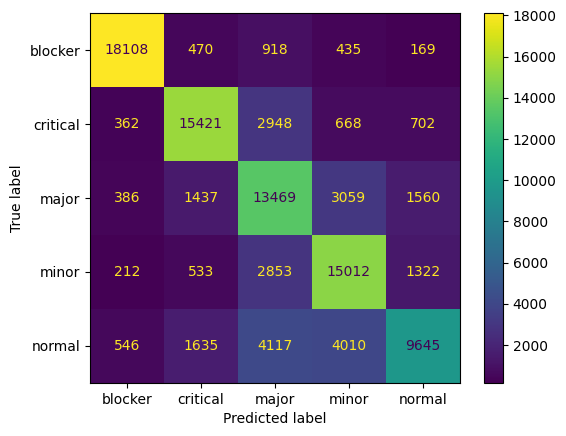

In [98]:
cm_display.plot()
plt.show()


In [99]:
from sklearn.metrics import classification_report

# assuming conf_mat is your multi-class confusion matrix
# target_names = ['minor', 'major', 'critical', 'blocker']
target_names = nb.classes_
print(classification_report(y_test, y_pred_class, target_names=target_names))


              precision    recall  f1-score   support

     blocker       0.92      0.90      0.91     20100
    critical       0.79      0.77      0.78     20101
       major       0.55      0.68      0.61     19911
       minor       0.65      0.75      0.70     19932
      normal       0.72      0.48      0.58     19953

    accuracy                           0.72     99997
   macro avg       0.73      0.72      0.71     99997
weighted avg       0.73      0.72      0.72     99997



In [101]:
#testing for one
%time ip = ["button color is wrong"]
ip_dtm = vect.transform(ip)
# ip_tfidf = tfidf_transformer.transform(ip_dtm)
nb.predict(ip_dtm)[0]

CPU times: user 19 µs, sys: 0 ns, total: 19 µs
Wall time: 33.9 µs


'minor'

In [24]:
# #pikcle the model and put into the jar
# import pickle
# pickle.dump(nb, open('pickle_jar/naive_bayes_model.pkl', 'wb'))
# pickle.dump(vect, open('pickle_jar/naive_bayes_vect.pkl', 'wb'))



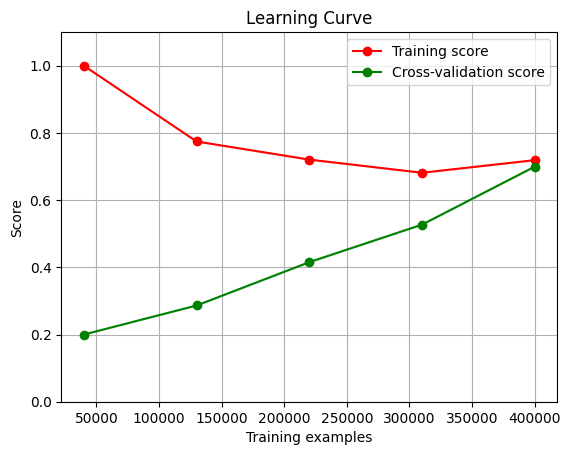

In [102]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

# Define the TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Fit the vectorizer to the text data and transform it
X = vectorizer.fit_transform(df['description'])
y = df['severity']

# Define your Multinomial Naive Bayes model
nb = MultinomialNB()

# Generate the learning curves
train_sizes, train_scores, test_scores = learning_curve(nb, X, y, cv=5)

# Calculate the mean and standard deviation of the training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curves
plt.figure()
plt.title('Learning Curve')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.ylim(0.0, 1.1)
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
plt.legend(loc='best')
plt.show()


In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Vectorize the text data using TfidfVectorizer
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(df['description'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Train the Naive Bayes model on the training data
nb = MultinomialNB()
nb.fit(X_train, y_train)

# Get the predicted probabilities of the classes for the test data
y_prob = nb.predict_proba(X_test)

# Use the predicted probabilities as input to the SVM model
svm = SVC(kernel='linear', C=1, random_state=42)
svm.fit(y_prob, y_test)

# Predict the classes of the test data using the Naive Bayes and SVM models
y_pred_nb = nb.predict(X_test)
y_pred_svm = svm.predict(y_prob)

# Calculate the accuracy score of the models on the test data
accuracy_nb = accuracy_score(y_test, y_pred_nb)
accuracy_svm = accuracy_score(y_test, y_pred_svm)

# Print the accuracy scores
print("Accuracy of Naive Bayes:", accuracy_nb)
print("Accuracy of SVM:", accuracy_svm)
